In [10]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from PIL import Image

In [7]:
from google.colab import files
# uploaded = files.upload()  # Upload Comp6721_Project_Dataset.zip

with zipfile.ZipFile("Comp6721_Project_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")


In [14]:
# =========================
# 2. Transformations
# =========================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# =========================
# 3. Dataset and loaders
# =========================
train_dir = "/content/Comp6721_Project_Dataset/Training"
test_dir  = "/content/Comp6721_Project_Dataset/Test"

full_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloaders
def get_loaders(batch_size):
    return {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size),
        'test': DataLoader(test_dataset, batch_size=batch_size)
    }


In [16]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
      nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
      nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    )
    self.fc = nn.Sequential(
          nn.Flatten(),
          nn.Linear(128 * 16 * 16, 256), nn.ReLU(),
          nn.Dropout(0.4),  # add dropout to reduce overfitting
          nn.Linear(256, 3)
      )

  def forward(self, x):
    return self.fc(self.conv(x))

In [20]:
def train_model(model, loaders, lr, epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # reduce LR every 5 epochs

    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in loaders['train']:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

        scheduler.step()  # update learning rate

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in loaders['val']:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        avg_loss = running_loss / len(loaders['train'].dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")  # Save best model

    return best_val_acc


In [21]:
# 6. Hyperparameter Grid
# =========================
results = []
lrs = [1e-3, 1e-4]
batches = [32, 64]

for lr in lrs:
    for bs in batches:
        print(f"\\nTraining with LR={lr}, BS={bs}")
        model = SimpleCNN()
        loaders = get_loaders(bs)
        val_acc = train_model(model, loaders, lr)
        results.append({"lr": lr, "batch_size": bs, "val_acc": val_acc})


\nTraining with LR=0.001, BS=32
Epoch 1, Loss: 0.8807, Val Acc: 0.6463
Epoch 2, Loss: 0.7054, Val Acc: 0.7043
Epoch 3, Loss: 0.5968, Val Acc: 0.7697
Epoch 4, Loss: 0.4903, Val Acc: 0.7767
Epoch 5, Loss: 0.3797, Val Acc: 0.7440
Epoch 6, Loss: 0.2119, Val Acc: 0.7877
Epoch 7, Loss: 0.1444, Val Acc: 0.7757
Epoch 8, Loss: 0.0980, Val Acc: 0.7797
Epoch 9, Loss: 0.0588, Val Acc: 0.7737
Epoch 10, Loss: 0.0533, Val Acc: 0.7720
Epoch 11, Loss: 0.0267, Val Acc: 0.7733
Epoch 12, Loss: 0.0197, Val Acc: 0.7773
Epoch 13, Loss: 0.0175, Val Acc: 0.7810
Epoch 14, Loss: 0.0145, Val Acc: 0.7800
Epoch 15, Loss: 0.0161, Val Acc: 0.7820
\nTraining with LR=0.001, BS=64
Epoch 1, Loss: 0.9568, Val Acc: 0.6423
Epoch 2, Loss: 0.7629, Val Acc: 0.7077
Epoch 3, Loss: 0.6533, Val Acc: 0.7353
Epoch 4, Loss: 0.5575, Val Acc: 0.7487
Epoch 5, Loss: 0.4467, Val Acc: 0.7610
Epoch 6, Loss: 0.3100, Val Acc: 0.7783
Epoch 7, Loss: 0.2323, Val Acc: 0.7597
Epoch 8, Loss: 0.1679, Val Acc: 0.7493
Epoch 9, Loss: 0.1108, Val Acc: 0

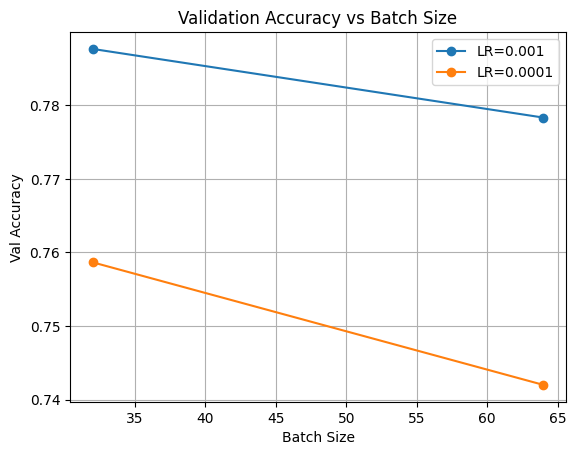

In [22]:
# 7. Save Results & Plot
# =========================
df = pd.DataFrame(results)
df.to_csv("results.csv", index=False)

plt.figure()
for lr in lrs:
    subset = df[df.lr == lr]
    plt.plot(subset.batch_size, subset.val_acc, marker='o', label=f"LR={lr}")
plt.title("Validation Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Val Accuracy")
plt.legend()
plt.grid()
plt.savefig("grid_search_plot.png")
plt.show()

                      precision    recall  f1-score   support

      library-indoor       0.67      0.76      0.71       100
       museum-indoor       0.80      0.69      0.74       100
shopping_mall-indoor       0.73      0.74      0.74       100

            accuracy                           0.73       300
           macro avg       0.74      0.73      0.73       300
        weighted avg       0.74      0.73      0.73       300



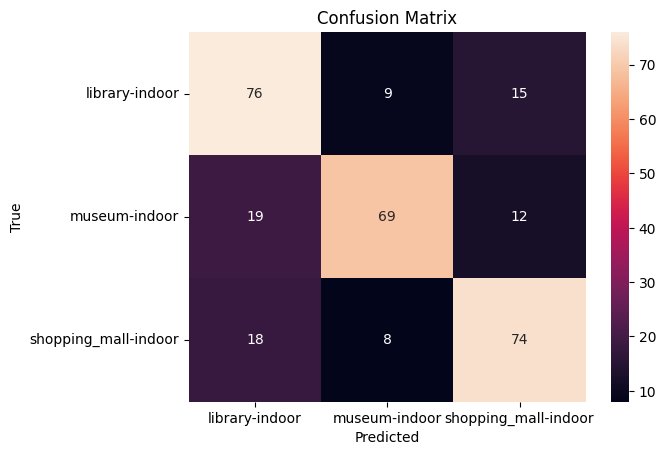

In [23]:
# 8. Final Test Evaluation
# =========================
model = SimpleCNN()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in get_loaders(32)['test']:
        preds = model(imgs).argmax(1)
        y_true += labels.tolist()
        y_pred += preds.tolist()

print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


Predicted class: library-indoor
Predicted class: library-indoor
Predicted class: shopping_mall-indoor


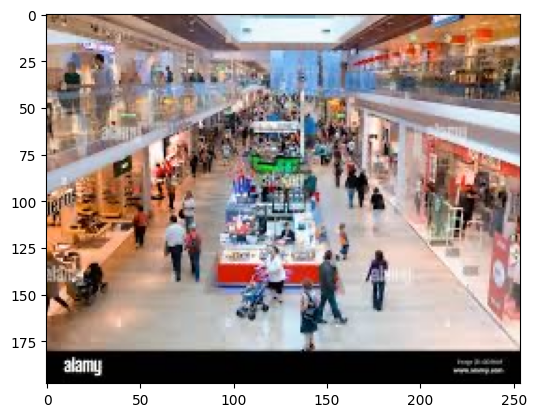

In [35]:
predict_image('/content/library_test.jpeg')
predict_image('/content/muse_test.jpeg')
predict_image('/content/shopping_mall_test.jpeg')

Predicted class: library-indoor


FileNotFoundError: [Errno 2] No such file or directory: '/content/museum_test.jpg'

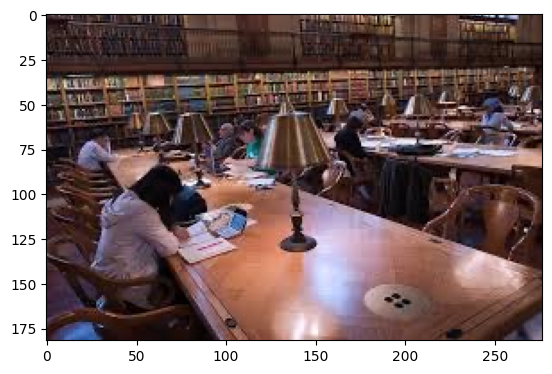

In [38]:
# 9. Demo: Predict a New Image
# =========================
def predict_image(path):
    image = Image.open(path).convert("RGB")
    plt.imshow(image)
    image = transform(image).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(1).item()
    print(f"Predicted class: {test_dataset.classes[pred]}")

# Example:
predict_image("/content/library_test.jpeg")
predict_image("/content/museum_test.jpg")
# predict_image("/content/shopping_mall_test.jpeg")

In [28]:
import os

# List all files in the /content directory
print(os.listdir('/content/'))

# List all files in the dataset's test directory
print(os.listdir('/content/Comp6721_Project_Dataset/Test/'))

['.config', 'confusion_matrix.png', 'best_model.pth', 'Comp6721_Project_Dataset', 'grid_search_plot.png', '__MACOSX', 'results.csv', 'Comp6721_Project_Dataset.zip', 'sample_data']
['shopping_mall-indoor', 'museum-indoor', 'library-indoor']
